In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath(".."))

from utils.ClaseAbdon import DataFrameAnalyzer

In [3]:
train = pd.read_csv('../data/train.csv')

In [5]:
df = train.copy()

In [6]:
df.set_index('ID',inplace=True)

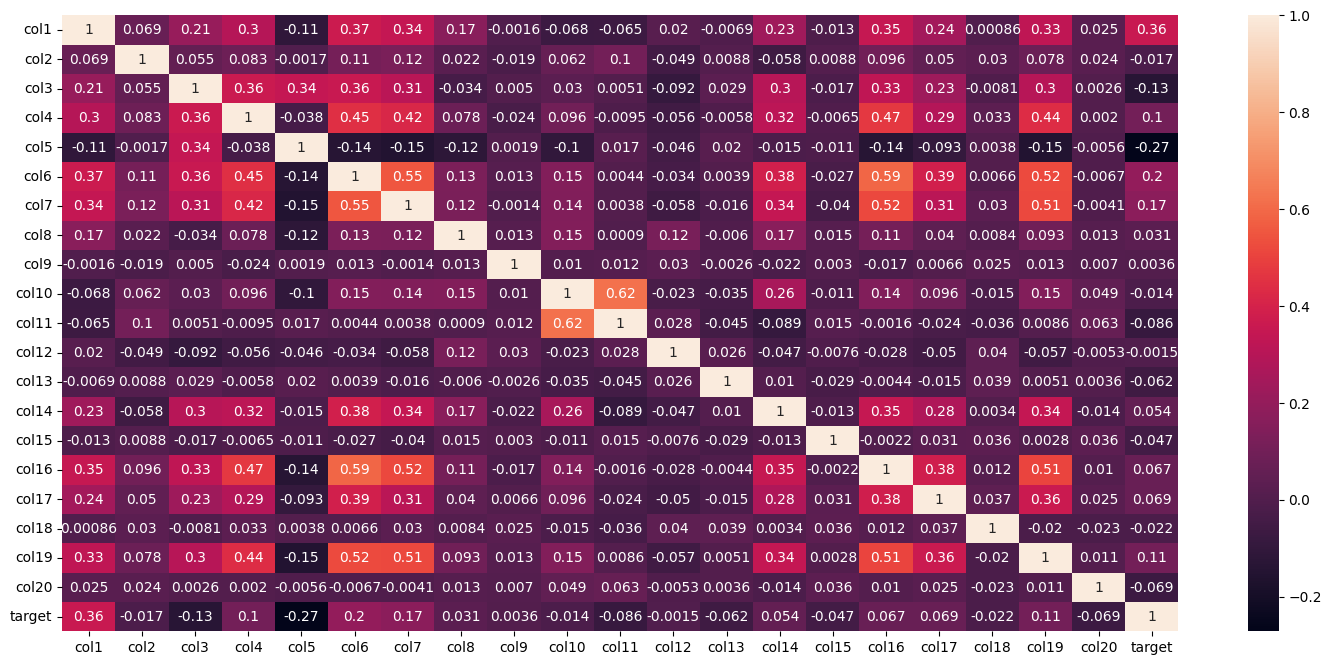

In [7]:
plt.figure(figsize=(18,8))

df_corr = df.corr()

sns.heatmap(df_corr,annot=True);

##### Conclusion general:
- Las variables col1 y col6 parecen ser las que tienen mayor impacto en target, pero no hay ninguna presion extremadamente fuerte. Esto sugiere que la target no depende linealmente de una sola variable, sino que podría estar influenciado por multiples factores o incluso por relaciones no lineales.
- No hay variable dominante con respecto a la target, pero col1 y col6 parecen tener algo de relevancia.
- Hay correlaciones fuertes entre algunas variables (col10 y col11, col6 y col16), lo que indica posible colinealidad.

In [8]:
df['target'].value_counts(normalize=True)
# vemos que hay desbalance claro en la target

target
0    0.885653
1    0.114347
Name: proportion, dtype: float64

In [10]:
## Modelos
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


In [11]:
X = df.drop(columns=['target'])
y = df['target']

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Configurar StratifiedKFold (5 folds estratificados)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir el modelo Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1) 

# Aplicar validación cruzada estratificada
f1_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)

# Mostrar resultado promedio
print(f"F1-score promedio en validación cruzada: {f1_scores.mean():.4f}")

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))

📊 F1-score promedio en validación cruzada: 0.7318
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       992
           1       0.94      0.73      0.82       128

    accuracy                           0.96      1120
   macro avg       0.95      0.86      0.90      1120
weighted avg       0.96      0.96      0.96      1120



In [14]:
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [5, 7, 9], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

# Realizar búsqueda en cuadrícula para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=skf, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo
rf_pred = best_rf.predict(X_test)

# Evaluar el modelo
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       992
           1       0.81      0.84      0.83       128

    accuracy                           0.96      1120
   macro avg       0.90      0.91      0.90      1120
weighted avg       0.96      0.96      0.96      1120

Mejores hiperparámetros: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='binary:logistic',  # Para clasificación binaria
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # Ajustar el peso de la clase minoritaria
    eval_metric='auc',  # Métrica de evaluación: AUC
    use_label_encoder=False,
    random_state=42, cv=skf
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

# Evaluar el modelo
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       992
           1       0.90      0.86      0.88       128

    accuracy                           0.97      1120
   macro avg       0.94      0.92      0.93      1120
weighted avg       0.97      0.97      0.97      1120



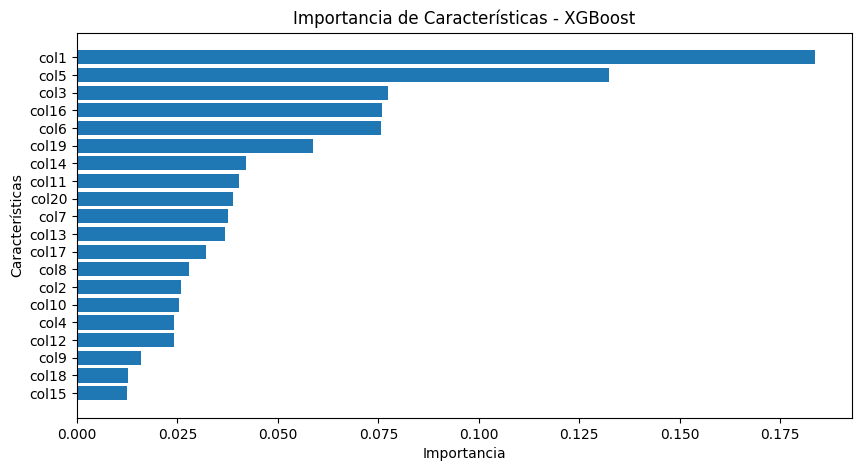

In [18]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de Características - XGBoost")
plt.gca().invert_yaxis()
plt.show()

### Conclusiones 

- Después de realizar pruebas eliminando columnas menos relevantes, no se observaron mejoras en el rendimiento del modelo; por el contrario, en algunos casos, el desempeño empeoró. Por ello, decidió conservar todas las columnas originales , ya que contribuyen de manera significativa a la calidad del modelo.
- Después de probar varios modelos, como Random Forest, SVC y Voting Classifier, el modelo que ofreció el mejor desempeño fue XGBoost. Tras un análisis detallado, se supervisa que este modelo logró los mejores resultados en comparación con los demás. Dado el evidente desequilibrio en la variable objetivo, XGBoost destacó por obtener los valores más óptimos en métricas clave como retirada y F1-score, lo que lo convierte en la mejor opción para este problema.